In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset.head())

   schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2        X3  \
0        76  1  0.081602   6   4   2   1   4  0.334544  0.648586 -1.310927   
1        76  1 -0.385869   4  12   2   1   4  0.334544  0.648586 -1.310927   
2        76  1  0.398184   6   4   2   0   4  0.334544  0.648586 -1.310927   
3        76  1 -0.175037   6   4   2   0   4  0.334544  0.648586 -1.310927   
4        76  1  0.884583   6   4   1   0   4  0.334544  0.648586 -1.310927   

         X4        X5  
0  0.224077 -0.426757  
1  0.224077 -0.426757  
2  0.224077 -0.426757  
3  0.224077 -0.426757  
4  0.224077 -0.426757  


In [2]:
# Columns are renamed to more descriptive names for clarity.
data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })


In [3]:
# Define covariates, treatment, and outcome
covariate_cols = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']
treatment_col = 'Z'
outcome_col = 'Y'

In [4]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

In [5]:
scaler = StandardScaler()

# Using .loc[] to ensure you're explicitly modifying the DataFrame
train_data.loc[:, covariate_cols] = scaler.fit_transform(train_data.loc[:, covariate_cols])
test_data.loc[:, covariate_cols] = scaler.transform(test_data.loc[:, covariate_cols])



C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.svm import SVR

In [7]:
# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 100)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.1, 0.2, 0.5]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'RidgeCV': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'LassoCV': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    }
}

In [8]:
import numpy as np
def grid_search_cv(data, treatment_col, outcome_col, covariate_cols, model, params, meta_learner):
    """
    Perform GridSearchCV for hyperparameter tuning and return the best model.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)

    print(f'Best parameters for {meta_learner} with {model.__class__.__name__}: {grid_search.best_params_}')

    return grid_search.best_estimator_


In [9]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an improved R-learner model to estimate CATE with robust residual handling and regularization.
    
    Parameters:
    - data: DataFrame containing the data
    - treatment_col: Column name for the treatment variable
    - outcome_col: Column name for the outcome variable
    - covariate_cols: List of column names for covariates
    - model: The base model to be used for predicting outcomes and treatment
    - regularization: Type of regularization to use ('ridge' or 'lasso')
    
    Returns:
    - tau_model: The trained model for estimating treatment effects
    - y_model: The outcome model
    - t_model: The treatment model
    - y_residual: Residuals of the outcome model
    - t_residual: Residuals of the treatment model
    """
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]

    # Fit outcome model
    y_model = cross_val_predict(model, X, y, cv=5)
    
    # Fit treatment model
    t_model = cross_val_predict(model, X, T, cv=5)
    
    # Calculate residuals
    y_residual = y - y_model
    t_residual = T - t_model
    
    # Regularization of residuals
    t_residual_clipped = np.clip(t_residual, a_min=0.01, a_max=None)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)
    
    # Add a small constant to prevent division by zero
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual_clipped + epsilon
    
#     # Use RidgeCV or LassoCV for additional regularization in the final model
#     regularization = 'ridge'
#     tau_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    regularization = 'lasso'
    tau_model = LassoCV(alphas=[0.1, 1.0, 10.0])
    
    
    # Fit the treatment effect model
    tau_model.fit(X, y_residual / t_residual_regularized)
    
    return tau_model, y_model, t_model, y_residual, t_residual

In [10]:
from sklearn.metrics import mean_squared_error

def evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, model, meta_learner):
    X_test = test_data[covariate_cols + [treatment_col]]
    y_test = test_data[outcome_col]
    if meta_learner == 'r':
        tau_model, _, _, _, _ = model
        predictions = tau_model.predict(test_data[covariate_cols])
        print("Predictions:")
        print(pd.Series(predictions).describe())
    mse = mean_squared_error(y_test, predictions)
    return mse

mse_results = []

for model_name, config in param_grids.items():
    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'R-Learner')
    r_model, y_model, t_model, y_residual, t_residual = r_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    mse_r = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (r_model, y_model, t_model, y_residual, t_residual), 'r')
    mse_results.append({'Meta-Learner': 'R-Learner', 'Model': model_name, 'MSE': mse_r})
    print(f"best_model:{best_model}")
mse_df = pd.DataFrame(mse_results)

Best parameters for R-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Predictions:
count    3.118000e+03
mean     2.215799e-01
std      1.407433e-14
min      2.215799e-01
25%      2.215799e-01
50%      2.215799e-01
75%      2.215799e-01
max      2.215799e-01
dtype: float64
best_model:RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200)
Best parameters for R-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Predictions:
count    3.118000e+03
mean     2.277407e-01
std      2.998083e-15
min      2.277407e-01
25%      2.277407e-01
50%      2.277407e-01
75%      2.277407e-01
max      2.277407e-01
dtype: float64
best_model:GradientBoostingRegressor(n_estimators=200)
Best parameters for R-Learner with MLPRegressor: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Predictions:
count    3.118000e+03
mean     2.132296e-01
std      1.268633e-14
min    

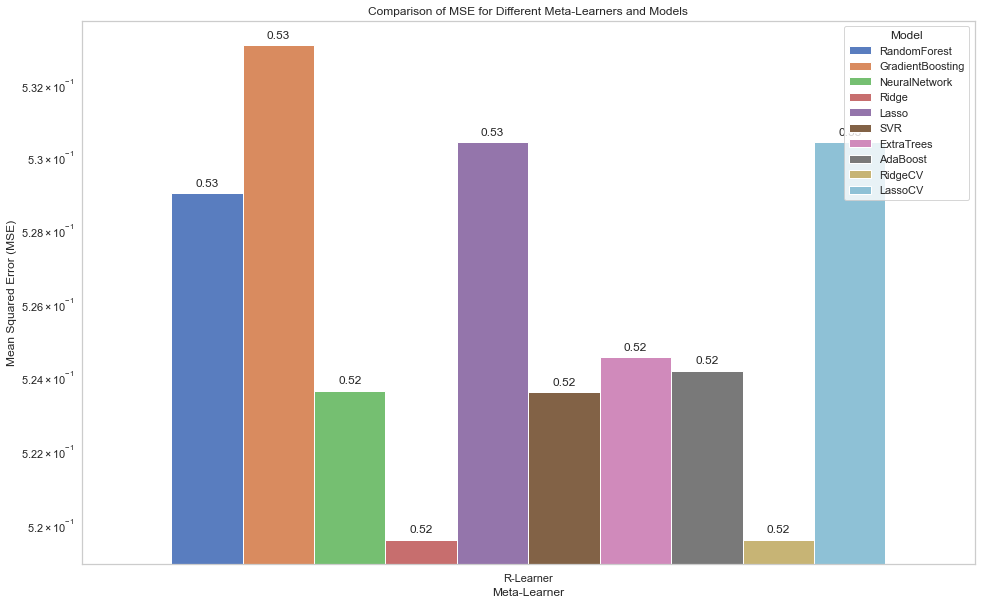

<Figure size 432x288 with 0 Axes>

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="whitegrid")

# plt.figure(figsize=(16, 10))
# sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df, palette="muted")
# plt.title('Comparison of MSE for Different Meta-Learners and Models')
# plt.xlabel('Meta-Learner')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.legend(title='Model')
# plt.yscale('log')
# plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(16, 10))
ax = sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df, palette="muted")
plt.title('Comparison of MSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Model')
plt.yscale('log')

# Adding the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()
plt.savefig("Using_Ridge_R-Learner_performance")
